In [31]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
df = pd.read_csv("all_stocks_5yr.csv")
df['Date'] = pd.to_datetime(df['date'])
df.drop(columns=['date'], inplace=True)
df = df.sort_values(by=['Date', 'Name']).reset_index(drop=True)

C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\768638635.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


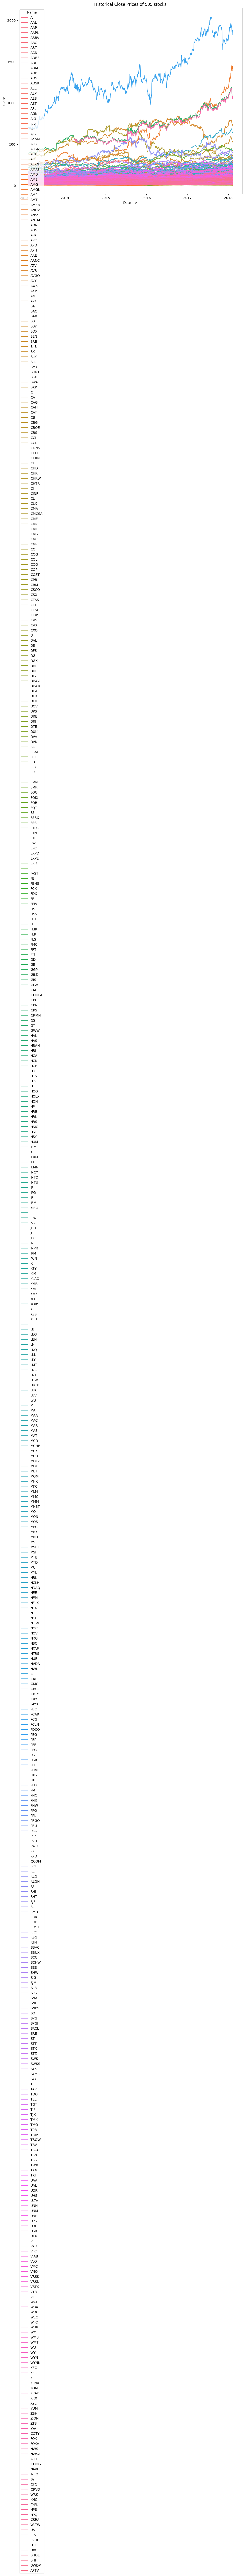

In [33]:
plt.figure(figsize=(12,10))
plt.title('Historical Close Prices of 505 stocks')
plt.xlabel('Date--->')
plt.ylabel('Close')
sns.lineplot(data=df,x='Date',y='close',hue='Name')
plt.tight_layout()

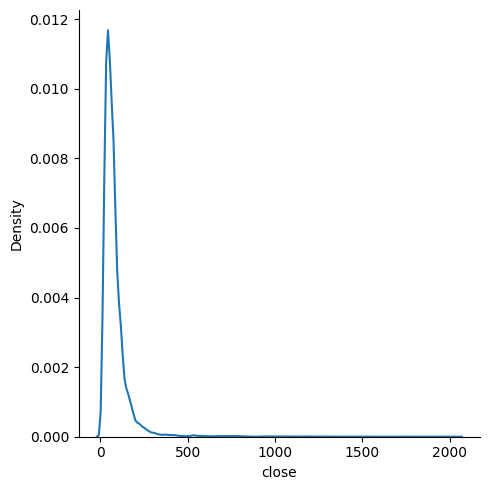

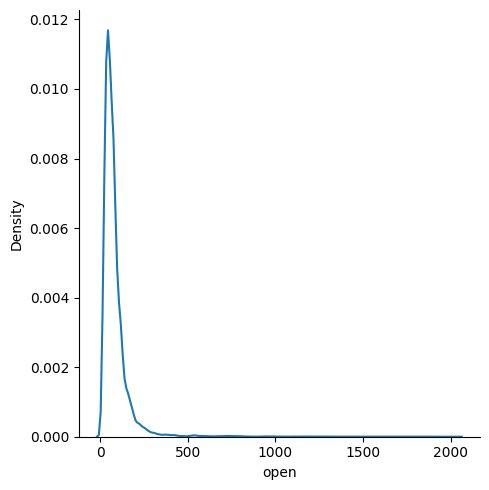

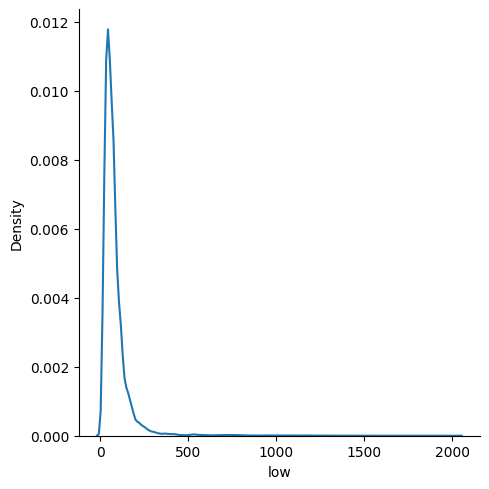

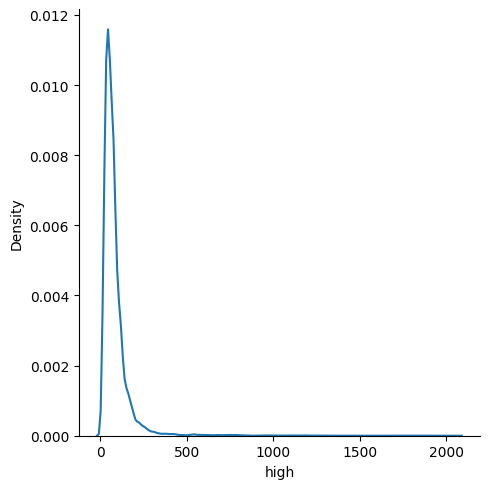

In [34]:
sns.displot(df['close'],kind='kde')
sns.displot(df['open'],kind='kde')
sns.displot(df['low'],kind='kde')
sns.displot(df['high'],kind='kde')

In [35]:
def compute_rsi(series: pd.Series, window: int = 14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100 - (100 / (1 + rs))

In [36]:
def downside_vol(x):
    x = x.dropna()
    return np.sqrt(np.mean(np.square(np.minimum(x, 0)))) if len(x) > 0 else np.nan
def add_features(df):
    df = df.copy()
    df = df.sort_values(['Name', 'Date'])

    def build_features(group):
        group['Ret_1d'] = group['close'].pct_change()
        group['Momentum_5d'] = group['close'].pct_change(periods=5)
        group['Momentum_10d'] = group['close'].pct_change(periods=10)
        group['Volatility_20d'] = group['Ret_1d'].rolling(20).std()
        group['Volatility_60d'] = group['Ret_1d'].rolling(60).std()
        group['AvgVol_10d'] = group['volume'].rolling(10).mean()
        group['RSI_14'] = compute_rsi(group['close'], window=14)
        group['DownsideVol_20d'] = group['Ret_1d'].rolling(20).apply(downside_vol, raw=False)
        group['Skew_20d'] = group['Ret_1d'].rolling(20).skew()
        group['RollingMean_5d'] = group['close'].rolling(5).mean()
        group['Price_to_AvgVolume'] = group['close'] / (group['volume'].rolling(10).mean() + 1e-9)
        return group

    df = df.groupby('Name', group_keys=False).apply(build_features)
    df['Momentum_5d_z'] = df.groupby('Date')['Momentum_5d'].transform(lambda x: (x - x.mean()) / (x.std() + 1e-9))

    df['Target'] = df.groupby('Name')['close'].shift(-5) / df['close'] - 1
    df['Target'] = df['Target'].clip(-0.15, 0.15)
    df['Target_demeaned'] = df.groupby('Date')['Target'].transform(lambda x: x - x.mean())

    df['MarketReturn'] = df.groupby('Date')['Target'].transform('mean')
    df['Beta_20d'] = df.groupby('Name', group_keys=False).apply(
        lambda group: group['Target'].rolling(20).corr(group['MarketReturn'])
    ).reset_index(drop=True)

    df = df.dropna(subset=['Momentum_5d', 'Momentum_10d', 'Volatility_20d', 'Volatility_60d',
                           'AvgVol_10d', 'RSI_14', 'DownsideVol_20d', 'Skew_20d', 'Beta_20d',
                           'RollingMean_5d', 'Price_to_AvgVolume', 'Target_demeaned'])
    return df



In [37]:
df = add_features(df)

C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\3260940946.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Name', group_keys=False).apply(build_features)
C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\3260940946.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['Beta_20d'] = df.groupby('Name', group_keys=False).apply(


In [38]:
feature_cols = ['Momentum_5d', 'Momentum_10d', 'Volatility_20d', 'Volatility_60d',
                'AvgVol_10d', 'RSI_14', 'Momentum_5d_z', 'DownsideVol_20d',
                'Skew_20d', 'Beta_20d', 'RollingMean_5d', 'Price_to_AvgVolume']
train_cutoff = datetime(2017, 1, 1)
train_df = df[df['Date'] < train_cutoff]
test_df = df[df['Date'] >= train_cutoff]

train_df = train_df[train_df['AvgVol_10d'] > train_df['AvgVol_10d'].quantile(0.2)]

X_train = train_df[feature_cols]
y_train = train_df['Target_demeaned']
X_test = test_df[feature_cols]
y_test = test_df['Target_demeaned']


In [39]:
df.head()

,open,high,low,close,volume,Name,Date,Ret_1d,Momentum_5d,Momentum_10d,...,RSI_14,DownsideVol_20d,Skew_20d,RollingMean_5d,Price_to_AvgVolume,Momentum_5d_z,Target,Target_demeaned,MarketReturn,Beta_20d
28556,42.18,42.410,41.90,42.40,3524022,A,2013-05-07,0.009524,0.023166,-0.004928,...,52.267818,0.013131,-0.596874,41.748,0.000013,0.078187,0.037028,0.019085,0.017943,0.861742
29032,42.40,42.950,42.30,42.94,2119765,A,2013-05-08,0.012736,0.039458,0.002100,...,61.538461,0.013131,-0.595516,42.074,0.000013,0.111476,0.063810,0.044155,0.019655,0.955741
29508,42.97,43.195,42.63,43.16,3159293,A,2013-05-09,0.005123,0.040501,0.010063,...,61.934156,0.013131,-1.279590,42.410,0.000013,0.585447,0.042400,0.025559,0.016841,0.671014
29985,43.12,43.850,43.04,43.63,4662252,A,2013-05-10,0.010890,0.050060,0.056416,...,67.181467,0.013131,-1.440802,42.826,0.000013,1.131761,0.044236,0.022901,0.021335,0.770428
30462,43.43,43.560,42.72,43.04,4260335,A,2013-05-13,-0.013523,0.024762,0.038109,...,54.291417,0.010419,-1.361486,43.034,0.000012,0.476709,0.076673,0.055472,0.021200,0.521891


<Axes: title={'center': 'Correlation among Different Features'}>

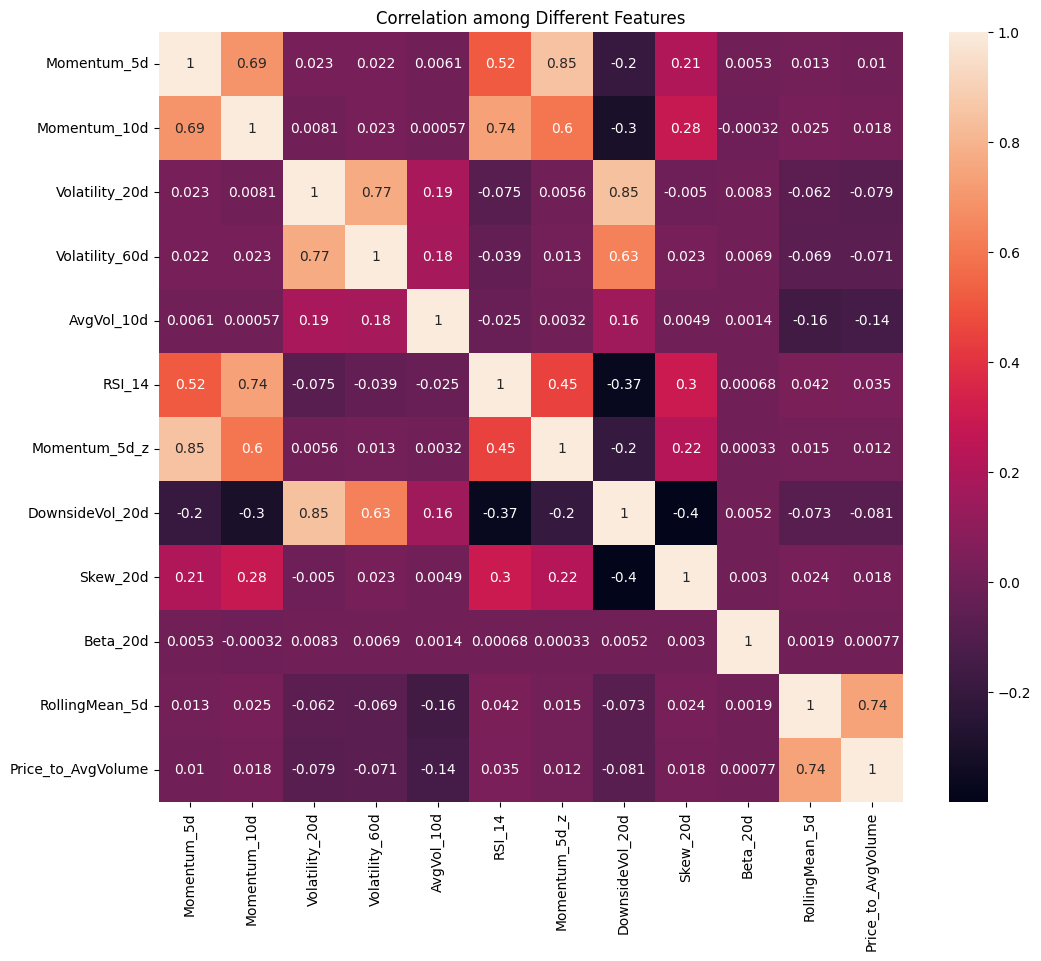

In [40]:
plt.figure(figsize=(12,10))
plt.title('Correlation among Different Features')
sns.heatmap(df[feature_cols].corr(numeric_only=True),annot=True)

In [41]:
model1 = LGBMRegressor(boosting_type='dart', n_estimators=1000, learning_rate=0.05,
                       num_leaves=31, feature_fraction=0.8, bagging_fraction=0.8, random_state=42)
model2 = CatBoostRegressor(iterations=500, learning_rate=0.03, depth=6, verbose=0, random_seed=42) #Selected using GridSearchCV unable to show due to hardware constraints
model3 = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 352905, number of used features: 12
[LightGBM] [Info] Start training from score -0.000042


RandomForestRegressor(max_depth=6, n_estimators=200, n_jobs=-1, random_state=42)

In [42]:
preds = {
    'lgbm': model1.predict(X_test),
    'cat': model2.predict(X_test),
    'rf':  model3.predict(X_test)
}

weights = {'lgbm': 0.4, 'cat': 0.4, 'rf': 0.2}


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [43]:
test_df['PredictedReturn'] = (
    weights['lgbm'] * preds['lgbm'] +
    weights['cat'] * preds['cat'] +
    weights['rf']  * preds['rf']
)

C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\4057872136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['PredictedReturn'] = (


In [44]:
test_df['PredictedReturn'] /= (test_df['Volatility_20d']  + 1e-9)

smoothed = test_df.groupby('Name')['PredictedReturn'].transform(lambda x: x.rolling(5, min_periods=1).mean())
test_df['PredictedSmoothed'] = smoothed

test_df['FinalSignal'] = test_df['PredictedSmoothed']
test_df['RankedSignal'] = test_df.groupby('Date')['FinalSignal'].rank(pct=True)


C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\3588791935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['PredictedReturn'] /= (test_df['Volatility_20d']  + 1e-9)
C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\3588791935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['PredictedSmoothed'] = smoothed
C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\3588791935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [45]:
def compute_metrics(df, signal_col, target_col):
    df = df.copy()
    df['rank'] = df.groupby('Date')[signal_col].rank(pct=True)
    df = df.sort_values(['Date', 'rank'], ascending=[True, False])

    df['strategy_return'] = df.groupby('Date').apply(lambda x: x[target_col] * (x['rank'] >= 0.95)).reset_index(level=0, drop=True)
    df['strategy_cum'] = (1 + df['strategy_return'].fillna(0)).groupby(df['Date']).prod().cumprod()

    daily_returns = df.groupby('Date')['strategy_return'].mean()
    cumulative_returns = (1 + daily_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    sharpe = daily_returns.mean() / (daily_returns.std() + 1e-9) * np.sqrt(252)
    calmar = daily_returns.mean() / abs(max_drawdown + 1e-9) * 252

    return {
        'Sharpe Ratio': sharpe,
        'Calmar Ratio': calmar,
        'Maximum Drawdown': max_drawdown,
        'Mean Information Coefficient': np.corrcoef(df[signal_col], df['Target'])[0, 1]
    }


In [46]:
results = compute_metrics(test_df, 'FinalSignal', 'Target_demeaned')
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Sharpe Ratio: 2.7345
Calmar Ratio: 2.1565
Maximum Drawdown: -0.0087
Mean Information Coefficient: 0.0134


C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\4236073590.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['strategy_return'] = df.groupby('Date').apply(lambda x: x[target_col] * (x['rank'] >= 0.95)).reset_index(level=0, drop=True)


In [47]:
def plot_feature_importance(model, feature_names, max_num_features=30):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    top_features = feature_importance_df.head(max_num_features)

    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()


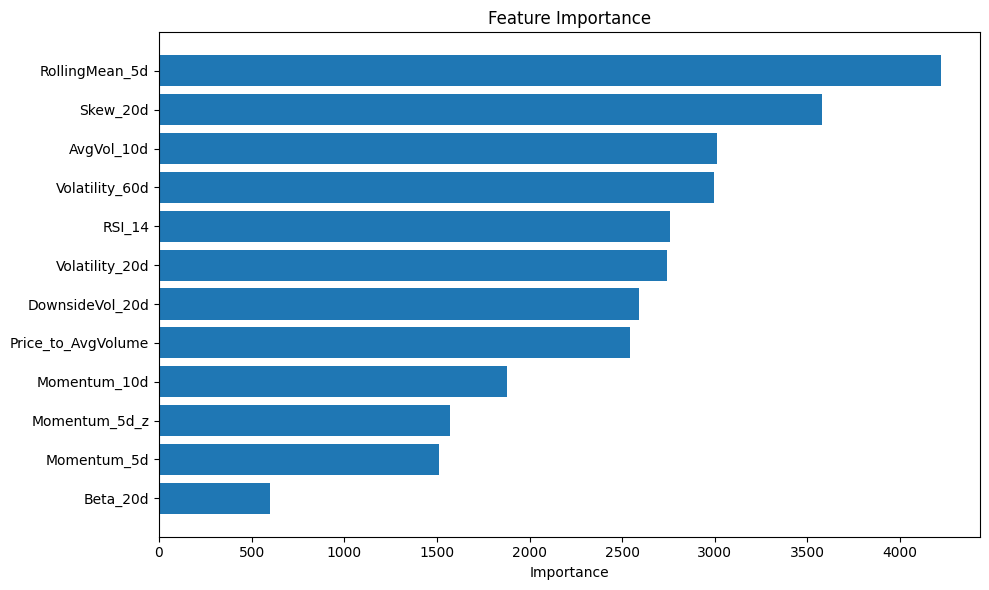

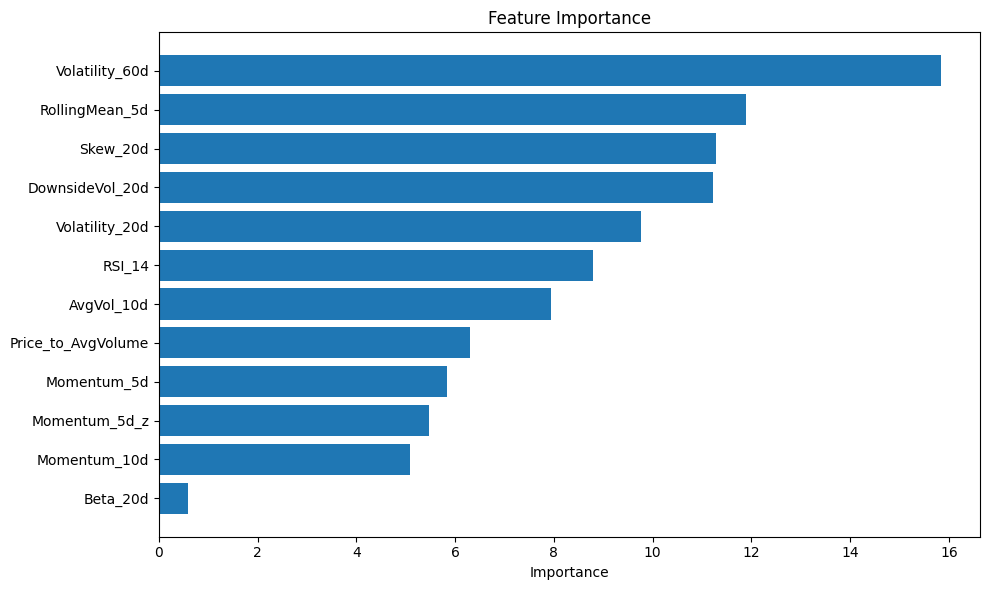

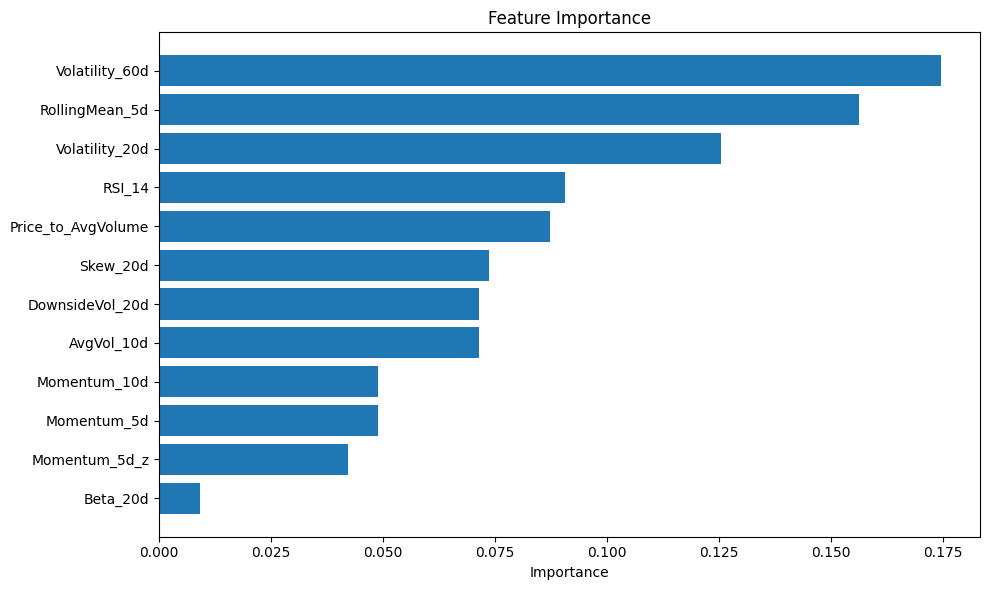

In [48]:
models=[model1,model2,model3]
for i in models:
   plot_feature_importance(i, feature_cols)

In [49]:
import matplotlib.pyplot as plt

def plot_cumulative_returns(df, top_k_percent=0.10):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    daily_returns = (
        df.groupby('Date')
        .apply(lambda x: x.sort_values('RankedSignal', ascending=False)
                         .head(int(len(x) * top_k_percent))['Target'].mean())
    )

    cum_returns = (1 + daily_returns).cumprod()

    plt.figure(figsize=(12, 6))
    plt.plot(cum_returns.index, cum_returns.values, label=f"Top {int(top_k_percent*100)}% Strategy", color='navy')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.title("Cumulative Strategy Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return cum_returns


C:\Users\rocki\AppData\Local\Temp\ipykernel_21016\3267483331.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('RankedSignal', ascending=False)


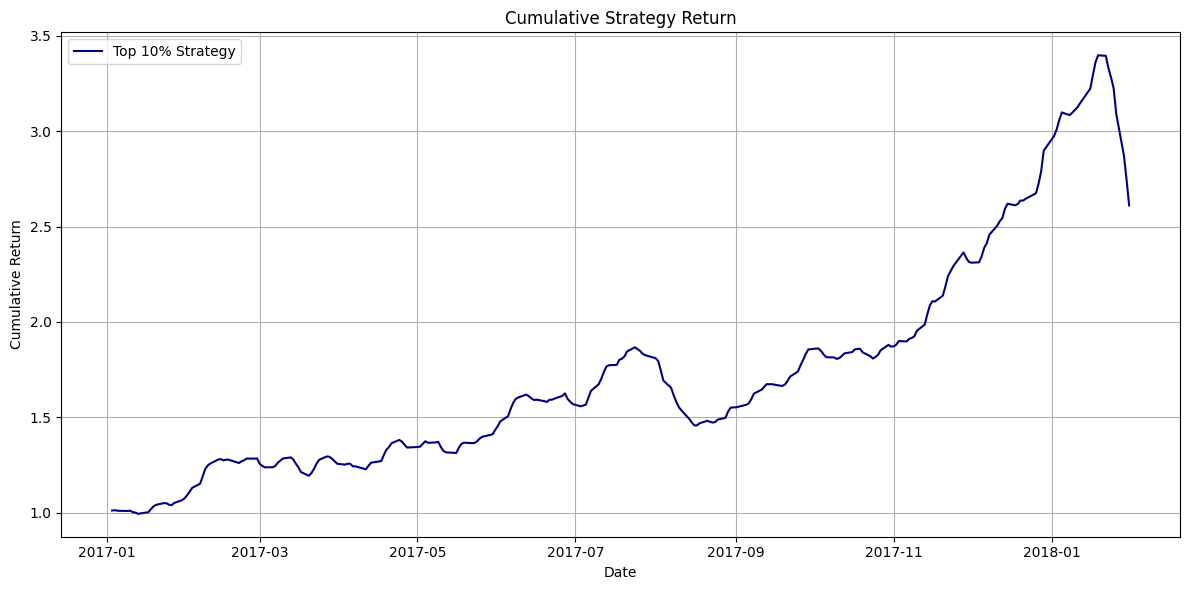

In [50]:
cum_returns = plot_cumulative_returns(test_df)

In [51]:
def cumulative_alpha_plot(test_df, signal_col='PredictedReturn', target_col='Target', top_k=0.10):
    df = test_df.copy()
    df = df.sort_values('Date')
    df['Rank'] = df.groupby('Date')[signal_col].rank(pct=True)
    selected = df[df['Rank'] >= 1 - top_k]

    daily_return_model = selected.groupby('Date')[target_col].mean()
    daily_return_baseline = df.groupby('Date')[target_col].mean()
    daily_alpha = daily_return_model - daily_return_baseline


    cumulative_model = (1 + daily_return_model).cumprod()
    cumulative_baseline = (1 + daily_return_baseline).cumprod()
    cumulative_alpha = (1 + daily_alpha).cumprod()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_model, label=f"Model Cumulative Return (Top {int(top_k*100)}%)", linewidth=2)
    plt.plot(cumulative_baseline, label="Market Average", linestyle='--')
    plt.plot(cumulative_alpha, label="Cumulative Alpha (Excess)", linestyle=':', linewidth=2.5)
    plt.title(f"Cumulative Return & Alpha vs Market (Top {int(top_k*100)}%)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


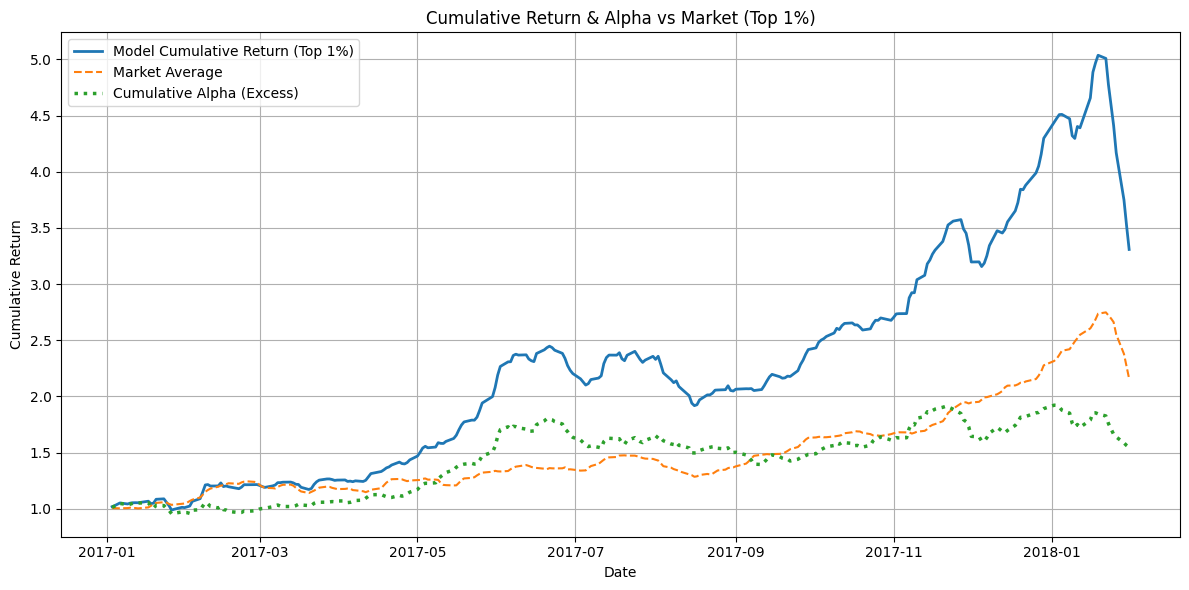

In [52]:
cumulative_alpha_plot(test_df, signal_col='PredictedReturn', target_col='Target', top_k=0.01)

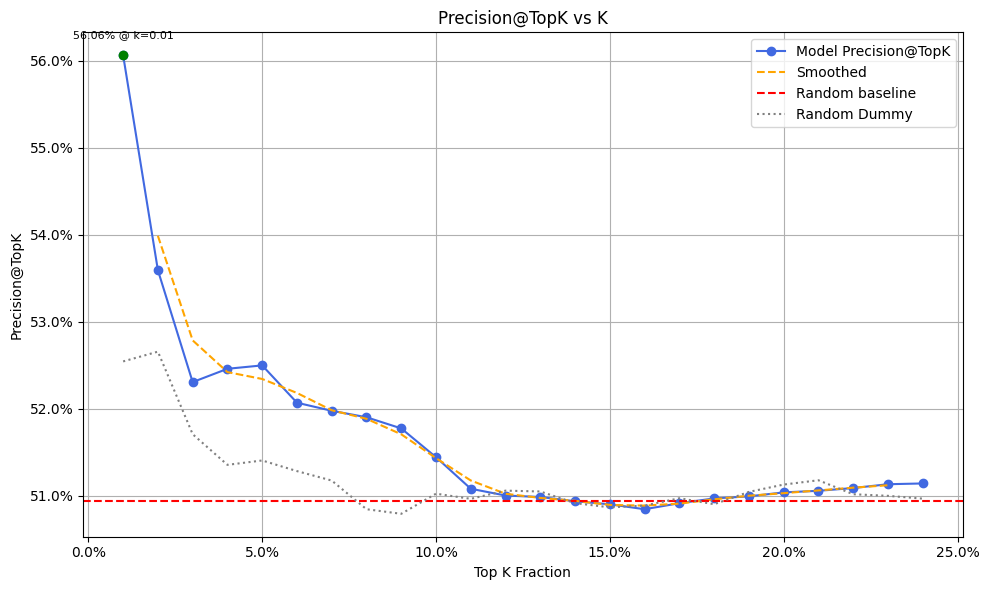

In [53]:

def precision_at_top_k(y_true, y_pred, k=0.1):
    df_eval = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    df_eval = df_eval.sort_values('y_pred', ascending=False)
    top_k = int(len(df_eval) * k)
    top_df = df_eval.head(top_k)
    return (top_df['y_true'] > 0).mean()
from matplotlib.ticker import PercentFormatter

ks = np.arange(0.01, 0.25, 0.01)
precisions = [precision_at_top_k(y_test, test_df['PredictedReturn'], k=k) for k in ks]
baseline = (y_test > 0).mean()

plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label='Model Precision@TopK', marker='o', color='royalblue')
precision_smooth = pd.Series(precisions).rolling(3, center=True).mean()
plt.plot(ks, precision_smooth, label='Smoothed', linestyle='--', color='orange')
plt.axhline(baseline, color='red', linestyle='--', label='Random baseline')
best_k = ks[np.argmax(precisions)]
best_precision = max(precisions)
plt.scatter(best_k, best_precision, color='green', zorder=5)
plt.text(best_k, best_precision + 0.002, f"{best_precision:.2%} @ k={best_k:.2f}", ha='center', fontsize=8)
random_preds = np.random.permutation(test_df['PredictedReturn'].values)
random_precisions = [precision_at_top_k(y_test, random_preds, k=k) for k in ks]
plt.plot(ks, random_precisions, label='Random Dummy', linestyle=':', color='gray')

plt.xlabel("Top K Fraction")
plt.ylabel("Precision@TopK")
plt.title("Precision@TopK vs K")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()
plt.show()


In [54]:
def compute_profitable_days(df, k=0.1, target_col='Target', pred_col='PredictedReturn', verbose=True):

    df = df.copy()
    df['Rank'] = df.groupby('Date')[pred_col].rank(pct=True, ascending=False)
    top_df = df[df['Rank'] <= k]

    daily_avg = top_df.groupby('Date')[target_col].mean()
    profitable_days = (daily_avg > 0).sum()
    total_days = daily_avg.count()
    win_rate = profitable_days / total_days if total_days > 0 else 0

    if verbose:
        print(f"Profitable Days: {profitable_days} / {total_days}")
        print(f"Win Rate: {win_rate * 100:.2f}%")

    return profitable_days, total_days, win_rate



In [55]:
compute_profitable_days(test_df, k=0.1, target_col='Target', pred_col='PredictedReturn')


Profitable Days: 174 / 272
Win Rate: 63.97%


(np.int64(174), np.int64(272), np.float64(0.6397058823529411))

In [56]:
def compute_strategy_return_series(df, signal_col='RankedSignal', target_col='Target', top_k=0.10):
    df = df.copy()
    df['Rank'] = df.groupby('Date')[signal_col].rank(pct=True, ascending=False)
    selected = df[df['Rank'] <= top_k]
    daily_return = selected.groupby('Date')[target_col].mean()
    cumulative_return = (1 + daily_return).cumprod()
    total_return = cumulative_return.iloc[-1] - 1

    return daily_return, cumulative_return, total_return


In [57]:
daily_ret, cum_ret, total = compute_strategy_return_series(test_df, signal_col='RankedSignal', target_col='Target', top_k=0.1)

print(f"Total Strategy Return over Test Period: {total:.2%}")


Total Strategy Return over Test Period: 161.05%


In [58]:
def predict_actual_cagr(df: pd.DataFrame, signal_col: str, top_k_percent: float = 0.10):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    if signal_col == 'PredictedReturn':
        df['RankedSignalForSelection'] = df.groupby('Date')[signal_col].rank(pct=True, ascending=False)
        selection_signal_col = 'RankedSignalForSelection'
    else:
        selection_signal_col = signal_col
    
    if 'RankedSignal' not in df.columns:
        print("Warning: 'RankedSignal' not found. Ranking 'PredictedReturn' for selection.")
        df['RankedSignal'] = df.groupby('Date')['PredictedReturn'].rank(pct=True, ascending=False)
    
    selected_stocks_daily = df[df['RankedSignal'] >= (1 - top_k_percent)]

    daily_returns_absolute = selected_stocks_daily.groupby('Date')['Target'].mean()

    cumulative_returns_absolute = (1 + daily_returns_absolute).cumprod()

    if len(cumulative_returns_absolute) == 0:
        return np.nan

    num_trading_days = len(cumulative_returns_absolute)
    
    if num_trading_days <= 1:
        return cumulative_returns_absolute.iloc[-1] - 1 if num_trading_days == 1 else 0.0

    cagr_value = cumulative_returns_absolute.iloc[-1]**(252/num_trading_days) - 1

    return cagr_value


In [59]:
actual_cagr_top10 = predict_actual_cagr(test_df, signal_col='RankedSignal', top_k_percent=0.1)
print(f"Estimated Actual CAGR (Top 10%): {actual_cagr_top10:.2%}")

Estimated Actual CAGR (Top 10%): 144.58%


In [60]:
import joblib
joblib.dump(model1, 'model_lgbm.joblib')
joblib.dump(model2, 'model_cat.joblib')
joblib.dump(model3, 'model_rf.joblib')

['model_rf.joblib']